# Elliptical Slice Sampling
The purpose of this notebook is to check if the `elliptic.py` file implementing Elliptical Slice Sampling works as expected, whilst demonstrating how it can be used to sample from the latent variable posterior $p(\mathbf{f} | \mathbf{y}, \boldsymbol{\theta})$.

In [1]:
import numpy as np

from matplotlib import pyplot as plt

from gproc.elliptic_cpp import ess_samples_probit
from gproc.generative import sample_at_x
from gproc.kernels import squared_exponential
from gproc.kernels import rational_quadratic
from gproc.kernels import periodic

## Data Generation

In [2]:
N = 500 # Data size
D = 1 # Data dimension

x = np.random.uniform(-1, 1, N * D).reshape(-1, D) # Reshape to N x D matrix
#y, prob_y, f = sample_at_x(x, kernel_fcn=periodic, kernel_params = {'lengthscale': 1, 'variance': 1.4, 'period':2})
y, prob_y, f = sample_at_x(x, kernel_fcn=squared_exponential, kernel_params = {'lengthscale': 0.1, 'variance': 1.4})

## Generate Latent Posterior Samples

In [3]:
model_lengthscale=0.1
model_variance=1.4
K = squared_exponential(x, x, lengthscale=model_lengthscale, variance=model_variance)
#K = rational_quadratic(x, x, lengthscale=0.1, variance=1.4, weighting=1)
#K = periodic(x, x, lengthscale=1, variance=1.4, period=2)
K_chol = np.linalg.cholesky(K + 0.0001*np.eye(K.shape[0]))
samples = ess_samples_probit(K_chol, y, 2500, 500)

100%|███████████████████████████████████████████████████████████████████████████████| 2999/2999 [01:34<00:00, 31.70it/s]


## Mean of Samples Against True Function and Laplace

### ESS Samples Mean

In [4]:
ess_mean = np.mean(samples, axis=0)

### Laplace Approximation

In [5]:
from gproc.laplace import laplace_approximation_probit, chol_inverse

laplace_mean, df_ll, laplace_cov, objective_history, converged = laplace_approximation_probit(y, chol_inverse(K))

In [6]:
laplace_samples = np.random.multivariate_normal(laplace_mean, laplace_cov, 2500)

## Plot Means

In [7]:
ess_mean.shape

(500,)

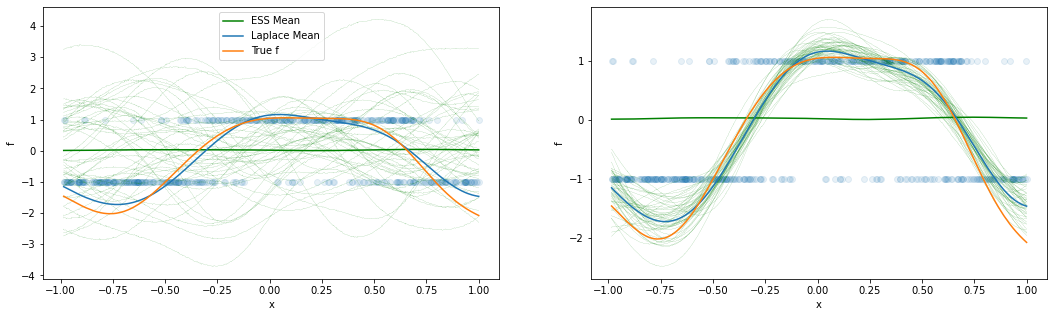

In [8]:
sort_ix = np.argsort(x.reshape(-1))

fig, axarr = plt.subplots(1, 2, figsize=(18, 5), gridspec_kw={'width_ratios': [1,1]})

axarr[0].scatter(x, y, alpha=0.1)
axarr[0].set_xlabel('x')
axarr[0].set_ylabel('f')

for i in range(0, samples.shape[0], 50):
    axarr[0].plot(x[sort_ix], samples[i, sort_ix], c = 'g', linewidth = 0.1)

axarr[0].plot(x[sort_ix], ess_mean[sort_ix], c='g', label='ESS Mean')
axarr[0].plot(x[sort_ix], laplace_mean[sort_ix], label='Laplace Mean')
axarr[0].plot(x[sort_ix], f[sort_ix], label='True f')

axarr[0].legend()

axarr[1].scatter(x, y, alpha=0.1)
axarr[1].set_xlabel('x')
axarr[1].set_ylabel('f')

for i in range(0, laplace_samples.shape[0], 50):
    axarr[1].plot(x[sort_ix], laplace_samples[i, sort_ix], c = 'g', linewidth = 0.1)

axarr[1].plot(x[sort_ix], ess_mean[sort_ix], c='g', label='ESS Mean')
axarr[1].plot(x[sort_ix], laplace_mean[sort_ix], label='Laplace Mean')
axarr[1].plot(x[sort_ix], f[sort_ix], label='True f')
axarr[0].legend()

(array([  1.,   0.,   0.,   1.,   1.,   2.,   5.,   7.,  15.,  11.,  12.,
         19.,  25.,  29.,  37.,  44.,  56.,  61.,  55.,  80.,  93.,  96.,
        103., 116., 131., 119., 147., 111., 132., 124., 119., 132.,  84.,
         80.,  78.,  59.,  69.,  48.,  42.,  31.,  24.,  23.,  21.,  15.,
         12.,   9.,   8.,   4.,   7.,   2.]),
 array([-4.05174215, -3.90028172, -3.74882128, -3.59736085, -3.44590041,
        -3.29443998, -3.14297954, -2.99151911, -2.84005867, -2.68859823,
        -2.5371378 , -2.38567736, -2.23421693, -2.08275649, -1.93129606,
        -1.77983562, -1.62837519, -1.47691475, -1.32545432, -1.17399388,
        -1.02253345, -0.87107301, -0.71961258, -0.56815214, -0.41669171,
        -0.26523127, -0.11377084,  0.0376896 ,  0.18915003,  0.34061047,
         0.4920709 ,  0.64353134,  0.79499177,  0.94645221,  1.09791264,
         1.24937308,  1.40083351,  1.55229395,  1.70375439,  1.85521482,
         2.00667526,  2.15813569,  2.30959613,  2.46105656,  2.612517  ,
 

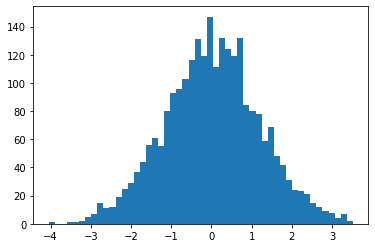

In [9]:
plt.hist(samples[:,0], bins=50)